In [1]:
import pandas as pd
import psycopg2
import sqlalchemy as sa
import numpy as np
import os
import tqdm
os.chdir("/usr/src/app")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Display columns
pd.options.display.max_columns = None
pd.options.display.width=None
pd.options.display.max_rows = 1000

# <font size=20>  Reference Court Dataset Creation

In [3]:
from deepsetstats.paths import (
    PATH_BIBLE_PLAYERS,
    PATH_TOURNAMENTS_NAMING,
    PATH_MASTER_TENNIS_TV,
    PATH_MASTER_GS,
    PATH_REFERENCE_VIDEOS,
    PATH_VIDEOS,
    PATH_ANNOTATIONS_REFERENCE_PARQUET,
    PATH_MASTER_VIDEOS,
    PATH_VIDEOS_METADATA,
    PATH_TEMPLATE_MATCHING,
    PATH_INTERVALS,
    PATH_INTERVALS_NOT_COURT,
    PATH_DATASET_COURT
)

from deepsetstats.dataset.court_detection import utils

In [4]:

from deepsetstats.dataset.court_detection import utils
from importlib import reload
utils = reload(utils)
Utils = utils.Utils

## Master of Videos

In [5]:
df_temp_match = pd.read_parquet(PATH_TEMPLATE_MATCHING, engine="pyarrow")
df_meta_videos = pd.read_parquet(PATH_VIDEOS_METADATA, engine="pyarrow")

In [6]:
vid2fps = df_meta_videos.set_index('video_id')['fps'].to_dict()
vid2frames = df_meta_videos.set_index('video_id')['frames'].to_dict()

## Select Tournaments

In [7]:
tournaments = sorted(df_temp_match["tournament_id"].unique())

## Find intervals of consecutive full-court frames

In [13]:
# Function to find largest consecutive interval
def find_largest_consecutive_interval(df, CONFIDENCE_THRESHOLD=5):
    results = []
    for video_id, group in tqdm.tqdm(df.groupby('video_id')):
        # Get frames per second
        fps = vid2fps.get(video_id, 60)

        # Remember we sampled template_matching at the seconds
        min_length_seconds = 4

        
        consecutive_interval = []
        for idx, row in group.iterrows():
            if row['confidence'] > CONFIDENCE_THRESHOLD:
                consecutive_interval.append(row['frame_num'])
            else:
                if len(consecutive_interval) >= min_length_seconds:
                    # If the so far accumulated consecutive frames
                    # are more than 4 seconds length, then
                    
                    results.append({
                        'video_id': video_id,
                        'tournament_id': row["tournament_id"],
                        'interval_start': consecutive_interval[0],
                        'interval_end': consecutive_interval[-1]
                    })
                # Empty again the consecutive interval
                consecutive_interval = []

        # If the video ended up in the middle of a court scene, count this as 
        # a consecutive interval if you gathered more than min_length_seconds seconds of interval
        if consecutive_interval:
            results.append({
                'video_id': video_id,
                'tournament_id': row["tournament_id"],
                'interval_start': consecutive_interval[0],
                'interval_end': consecutive_interval[-1]
            })

    return pd.DataFrame(results)

# Function to find lowest confidence consecutive interval
def find_lowest_consecutive_interval(df, CONFIDENCE_THRESHOLD=2):
    results = []
    for video_id, group in tqdm.tqdm(df.groupby('video_id')):
        # Get frames per second
        fps = vid2fps.get(video_id, 60)

        # Remember we sampled template_matching at the seconds
        min_length_seconds = 4

        
        consecutive_interval = []
        for idx, row in group.iterrows():
            if row['confidence'] < CONFIDENCE_THRESHOLD:
                consecutive_interval.append(row['frame_num'])
            else:
                if len(consecutive_interval) >= min_length_seconds:
                    # If the so far accumulated consecutive frames
                    # are more than 4 seconds length, then
                    
                    results.append({
                        'video_id': video_id,
                        'tournament_id': row["tournament_id"],
                        'interval_start': consecutive_interval[0],
                        'interval_end': consecutive_interval[-1]
                    })
                # Empty again the consecutive interval
                consecutive_interval = []

        # If the video ended up in the middle of a court scene, count this as 
        # a consecutive interval if you gathered more than min_length_seconds seconds of interval
        if consecutive_interval:
            results.append({
                'video_id': video_id,
                'tournament_id': row["tournament_id"],
                'interval_start': consecutive_interval[0],
                'interval_end': consecutive_interval[-1]
            })

    return pd.DataFrame(results)

### High confidence of seeing court intervals

In [12]:
# Specify the confidence threshold
CONFIDENCE_THRESHOLD = 4

# Find the largest consecutive intervals
df_intervals = find_largest_consecutive_interval(df_temp_match, CONFIDENCE_THRESHOLD)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2286/2286 [01:09<00:00, 32.86it/s]


### High confidence of NOT seeing court intervals

In [14]:
# Specify the confidence threshold
CONFIDENCE_THRESHOLD = 2

# Find the largest consecutive intervals
df_intervals_low = find_lowest_consecutive_interval(df_temp_match, CONFIDENCE_THRESHOLD)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286/2286 [00:51<00:00, 44.54it/s]


## Annotate intervals

In [15]:
def annotate_interval(df):
    # Bring fps
    df["fps"] = df["video_id"].map(vid2fps)
    
    # Starting and ending seconds of court
    df["sec_start"] = df["interval_start"] / df["fps"]
    df["sec_end"] = df["interval_end"] / df["fps"]
    df["interval_duration"] = df["interval_end"] - df["interval_start"]
    
    # Create interval_id
    df["interval_id"] = df.groupby("video_id").cumcount() + 1
    return df

In [ ]:
# Annotate intervals for COURT and NOT COURT
df_intervals = annotate_interval(df_intervals)
df_intervals_low = annotate_interval(df_intervals_low)

# Save intervals
# df_intervals.to_parquet(PATH_INTERVALS, engine="pyarrow")
# df_intervals = pd.read_parquet(PATH_INTERVALS, engine="pyarrow")

# Save intervals
# df_intervals_low.to_parquet(PATH_INTERVALS_NOT_COURT, engine="pyarrow")
# df_intervals_low = pd.read_parquet(PATH_INTERVALS_NOT_COURT, engine="pyarrow")

## Statistics of goodness of videos coverage

In [22]:
# Count the number of intervals per video, which will indicate
# that a video with many intervals, has good content (many frames
# identified similar to the reference court)to be labelled
df_num_intervals = df_intervals.groupby("video_id").agg({
    "interval_start": "count",
    "interval_duration": "sum",
    
    
}).reset_index() \
    .rename(columns={
        "interval_start": "num_intervals", 
        "interval_duration": "total_intervals_duration"
    }).sort_values("num_intervals", ascending=False)
df_num_intervals["total_frames"] = df_num_intervals["video_id"].map(vid2frames)

# Coverage
df_num_intervals["coverage"] = df_num_intervals["total_intervals_duration"] / df_num_intervals["total_frames"]

df_num_intervals.sort_values("coverage", ascending=False, inplace=True)

In [23]:
df_coverage = df_num_intervals["coverage"].describe(percentiles=np.linspace(0,1,11)).reset_index()
df_coverage

index     coverage
0   count  1796.000000
1    mean     0.322907
2     std     0.235548
3     min     0.000000
4      0%     0.000000
5     10%     0.029043
6     20%     0.071239
7     30%     0.129308
8     40%     0.210652
9     50%     0.293486
10    60%     0.401843
11    70%     0.492333
12    80%     0.575570
13    90%     0.651430
14   100%     0.960748
15    max     0.960748

# Example 

### Inspect video of Court

In [24]:
df_intervals.video_id.unique()[:20]

array(['-3ZqY8NTd7w', '-Jy7kaYd4bs', '-s4E0Le-_IM', '00Yz4xddRiw',
       '02B9jvDlHck', '0IyALNfT1UU', '0PhnAJx4kC0', '0W9X4P9Dg30',
       '0mnkGoIyxKE', '1StqQk0-Zzo', '1ZaLEQyWHRI', '1bJXbAvOny0',
       '1gOAgNZb70w', '1gmdM8hXWrw', '1sVitGNa5sg', '1swLooJYfOY',
       '23d6L0wQTRs', '26Oz7fLSvlk', '275MxgzMK4s', '29mazOhtJWY'],
      dtype=object)

In [25]:
vid_id = "rEJXUZDGxkU"
df_intervals[df_intervals["video_id"] == vid_id].head(20)

video_id  tournament_id  interval_start  interval_end  fps  \
29081  rEJXUZDGxkU             45               0          6240   60   
29082  rEJXUZDGxkU             45            6360         13680   60   

       sec_start  sec_end  interval_duration  interval_id  
29081        0.0    104.0               6240            1  
29082      106.0    228.0               7320            2

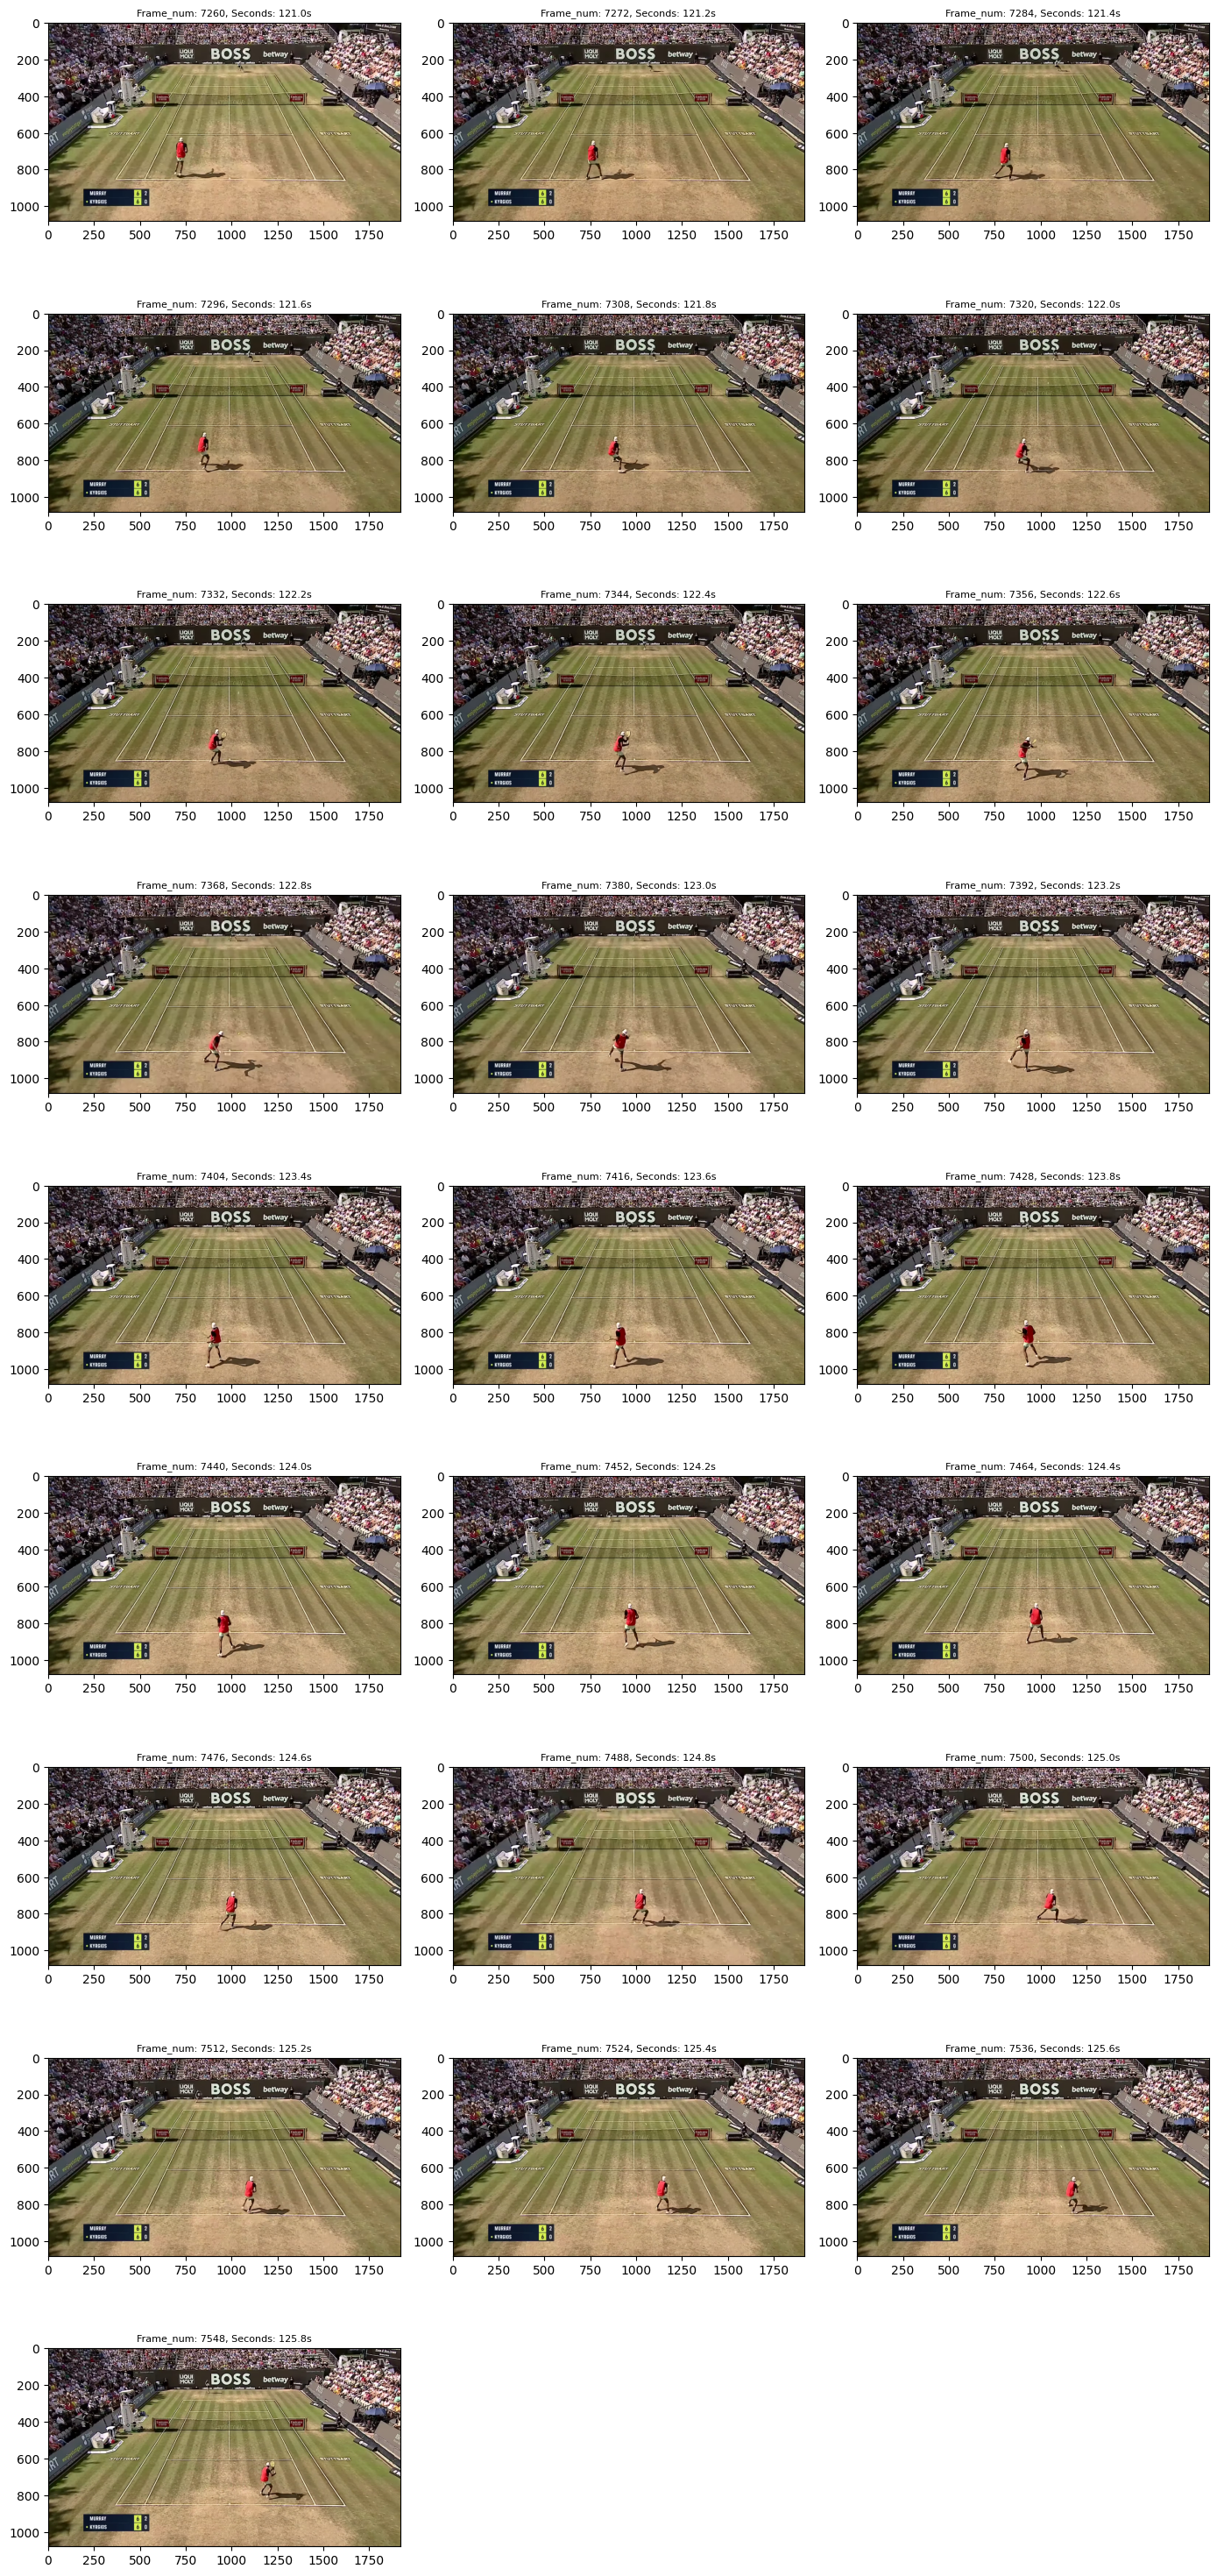

In [31]:
vid_id = "rEJXUZDGxkU"
fps = vid2fps[vid_id]
start = 7260
end = 7560

Utils.plot_range_frames(vid_id, start, end, fps, step_size=12, figsize=(14,30))

### Inspect video of NOT Court

In [26]:
df_intervals_low.video_id.unique()[:20]

array(['-3ZqY8NTd7w', '-Jy7kaYd4bs', '-lmE6hoxY3Y', '-s4E0Le-_IM',
       '00Yz4xddRiw', '02B9jvDlHck', '0IyALNfT1UU', '0PhnAJx4kC0',
       '0W9X4P9Dg30', '0mnkGoIyxKE', '1QkVs2MXtzg', '1StqQk0-Zzo',
       '1ZaLEQyWHRI', '1bJXbAvOny0', '1gOAgNZb70w', '1gmdM8hXWrw',
       '1pqsqJ7CdnE', '1sVitGNa5sg', '1swLooJYfOY', '23d6L0wQTRs'],
      dtype=object)

In [28]:
vid_id = "00Yz4xddRiw"
df_intervals_low[df_intervals_low["video_id"] == vid_id].head(10)

video_id  tournament_id  interval_start  interval_end  fps  sec_start  \
52  00Yz4xddRiw              0             775           900   25       31.0   
53  00Yz4xddRiw              0            1675          1750   25       67.0   
54  00Yz4xddRiw              0            1950          2050   25       78.0   
55  00Yz4xddRiw              0            2525          2675   25      101.0   
56  00Yz4xddRiw              0            2850          3100   25      114.0   
57  00Yz4xddRiw              0            3325          3425   25      133.0   
58  00Yz4xddRiw              0            4125          4250   25      165.0   
59  00Yz4xddRiw              0            4600          4725   25      184.0   
60  00Yz4xddRiw              0            5025          5125   25      201.0   
61  00Yz4xddRiw              0            6175          6275   25      247.0   

    sec_end  interval_duration  interval_id  
52     36.0                125            1  
53     70.0                 75            2  
54     82.0                100            3  
55    107.0                150            4  
56    124.0                250            5  
57    137.0                100            6  
58    170.0                125            7  
59    189.0                125            8  
60    205.0                100            9  
61    251.0                100           10

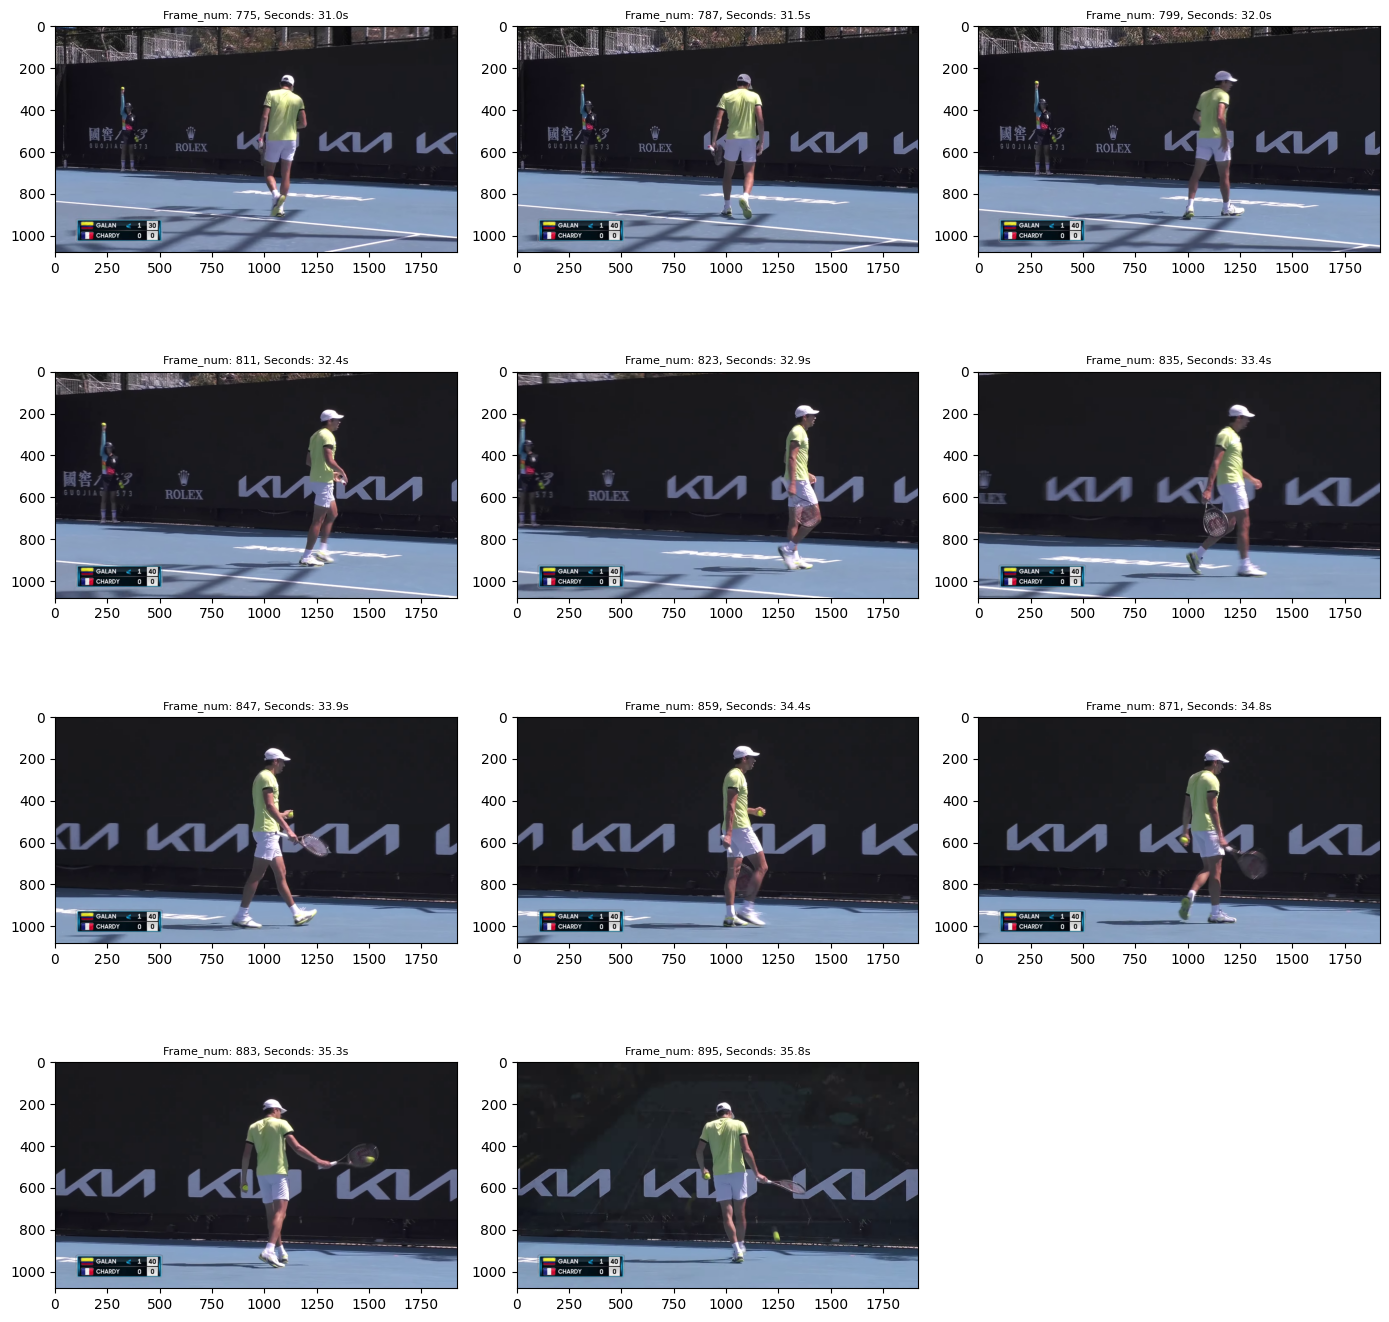

In [30]:
vid_id = "00Yz4xddRiw"
fps = vid2fps[vid_id]
start = 775
end = 900

Utils.plot_range_frames(vid_id, start, end, fps, step_size=12, figsize=(14,14))

# <font size=18> Iterate on intervals and create dataset of images

In [12]:
from importlib import reload
utils = reload(utils)
Utils = utils.Utils

In [70]:
COLS = ["tournament_id", "video_id", "interval_id", "frame_id", "is_court", "name"]

def create_sample_name(tournament_id, video_id, interval_id, frame_num):
    """
    Method to create the reference court images used to set the reference keypoints
    of the corners of the tennis court
    """
    # Decide if is court shown or not
    iscourt = True
    if interval_id == 0:
        iscourt = False

    # Naming of file starts different if is court
    if iscourt:
        prefix = "court"
    else:
        prefix = "nocourt"
    return f"{prefix}___t{tournament_id}___v{video_id}___i{interval_id}___f{frame_num}.png"


def create_d_dataset_ref_court():
    return {
        cc: [] for cc in COLS
    }

def update_dict(d, *args):
    for arg, col in zip(args, COLS):
        d[col].append(arg)

In [71]:
# Set a random seed (you can use any integer value)
np.random.seed(52)
MAX_SAMPLES_GS = 1
MAX_SAMPLES_MASTERS = 5
set_grandslams = {0, 1, 2, 3}
NULL_COURT_INTERVAL_ID = 0
d_dataset_ref_court = create_d_dataset_ref_court()
skipped_videos = set()

for idx_is_court, df_it in enumerate([df_intervals_low, df_intervals]):
    # idx_is_court: 0 (i.e False) for the intervals dataframe of not courts fully visible
    # idx_is_court: 1 (i.e True) for the intervals dataframe of courts visible
        
    for tournament_id, group in tqdm.tqdm(df_it.groupby('tournament_id')):
        
        # Check if grand slam, cause we are going to sample less, since more videos are from Grand Slams
        is_grandslam = tournament_id in set_grandslams
        
        for video_id, df_intervals_video in group.groupby('video_id'):
                
            # Ensure interval start always is smaller than interval end
            df_intervals_video = df_intervals_video[df_intervals_video["interval_start"] < df_intervals_video["interval_end"]].copy()
    
            # Ensure we still have samples
            if len(df_intervals_video) < 1:
                # print(f"Skipping video {video_id} for interval consistency (check 1)")
                skipped_videos.add(video_id)
                continue
    
    
            # Pick a sample between interval_start and interval_end
            df_intervals_video["frame_num_selected"] = np.random.randint(df_intervals_video["interval_start"], df_intervals_video["interval_end"])
            
            # Sample intervals from this video
            num_intervals = len(df_intervals_video)
            max_samples_selection = MAX_SAMPLES_GS if is_grandslam else MAX_SAMPLES_MASTERS
            num_sampling = min(max_samples_selection, num_intervals)
    
            # Sample it
            df_sample = df_intervals_video.sample(num_sampling)
    
            # Iterate through this dataframe
            for idx, row in df_sample.iterrows():
                # All the samples of that dataframe are either all court or all no court (this is why we have the outer most for loop)
                is_court = True if idx_is_court == 1 else False
                
                # Set the interval_id to 0 if the frame is not from a court
                # (a frame inside the interval start and end of that interval_id)
                interval_id = row["interval_id"] if is_court else NULL_COURT_INTERVAL_ID
                
                # Frame number selected
                frame_num = row["frame_num_selected"]

                # Create sample name
                img_name = create_sample_name(
                    tournament_id=tournament_id,
                    video_id=video_id,
                    interval_id=interval_id,
                    frame_num=frame_num
                )
    
                # Register sample
                # "tournament_id", "video_id", "interval_id", "frame_id", "is_court", "name"
                update_dict(d_dataset_ref_court, tournament_id, video_id, interval_id, frame_num, is_court, img_name)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 30.87it/s]


In [79]:
df_dataset_ref_court = pd.DataFrame(d_dataset_ref_court)
df_dataset_ref_court.to_parquet(PATH_DATASET_COURT, engine="pyarrow")

In [75]:
# Check the number of images per tournament
# df_dataset_ref_court.groupby("tournament_id")["name"].count().reset_index().sort_values("tournament_id")

# Plot a frame

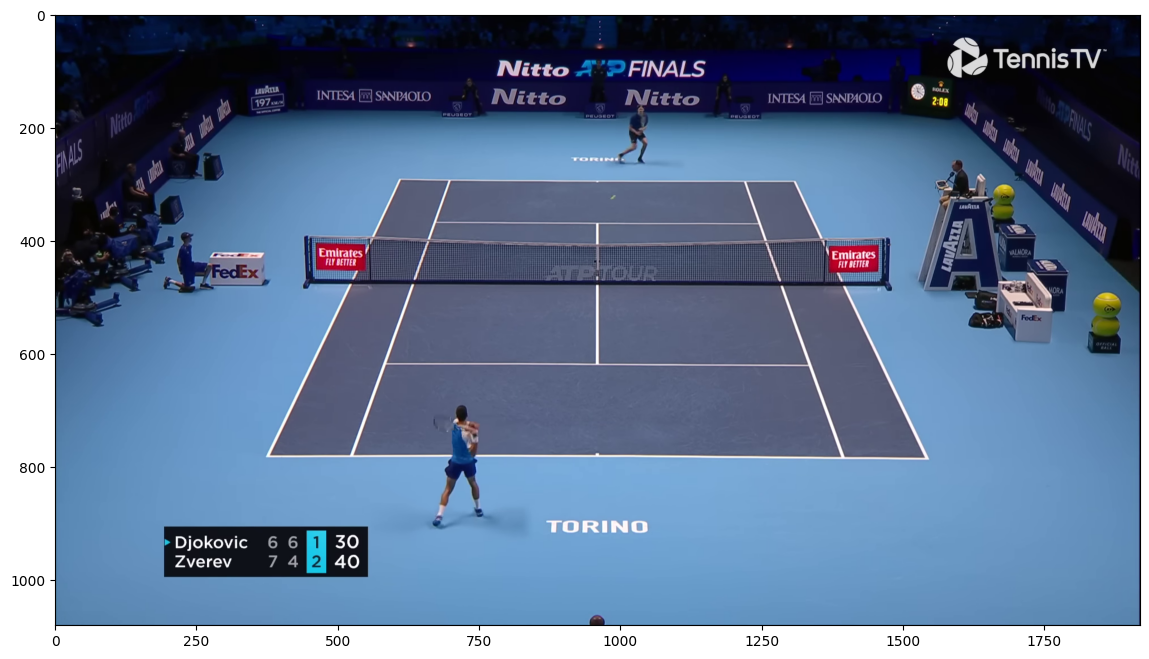

In [59]:
vid_id = "dsALS4dDxDs"
frame_id = 33433
Utils.plot_frame_video(vid_id, frame_id)

<font size=20> Images Creation

In [84]:
import os
from os.path import join as j
import pandas as pd
import tqdm
import shutil
import cv2
os.chdir("/usr/src/app")

In [ ]:
from deepsetstats.paths import (
    PATH_DATASET_COURT,
    PATH_IMAGES_DATASET_COURT
)

In [85]:
from deepsetstats.dataset.court_detection import utils
from importlib import reload
utils = reload(utils)
Utils = utils.Utils

In [80]:
df = pd.read_parquet(PATH_DATASET_COURT, engine="pyarrow")

# [Deprecated] Separate samples to directories (court, not_court)

In [66]:
path = "" # DEPRECATED

In [30]:
PATH_FOLDER_OF_COURT = "court"
PATH_FOLDER_OF_NO_COURT = "not_court"

def move_to_folders(path):
    for folder in tqdm.tqdm(os.listdir(path)):
        path_folder = j(path, folder)
        if not os.path.isdir(path_folder):
            continue
    
        # List images in the folder
        l_imgs = os.listdir(path_folder)
        l_imgs = [xx for xx in l_imgs if xx.endswith(".png")]
    
        # Create two dirs
        path_court = j(path_folder, PATH_FOLDER_OF_COURT)
        path_not_court = j(path_folder, PATH_FOLDER_OF_NO_COURT)
        os.makedirs(path_court, exist_ok=True)
        os.makedirs(path_not_court, exist_ok=True)
    
        # For each image move it to the folder
        for img in l_imgs:
            if "___i0___" in img:
                dest_folder = PATH_FOLDER_OF_NO_COURT
            else:
                dest_folder = PATH_FOLDER_OF_COURT
            # Move the image to the right folder
            path_dest = j(path_folder, dest_folder, img)
            path_src = j(path_folder, img)
            shutil.move(src=path_src, dst=path_dest)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:38<00:00,  1.69it/s]


# Save frames as images

In [ ]:
os.makedirs(PATH_IMAGES_DATASET_COURT, exist_ok=True)
for tournament_id, df_tour in tqdm.tqdm(df.groupby('tournament_id')):
    
    # Create a folder for each tournament
    path_folder_tourid = j(PATH_IMAGES_DATASET_COURT, f'tournament_id={tournament_id}')
    os.makedirs(path_folder_tourid, exist_ok=True)

    # Go video by video saving the frames
    for video_id, df_vid in df_tour.groupby('video_id'):
        # Get the video path
        path_video = Utils.path_video(video_id)

        # Get the list of frames selected by this video and its image name
        frames = df_vid["frame_id"].tolist()
        img_names = df_vid["name"].tolist()

        # Load the frames as numpy arrays (using threading for efficiently loading)
        d_frames = Utils.get_frames(path_video, frame_numbers=frames)

        # For each frame, save it
        for idx in range(len(df_vid)):
            frame_id = frames[idx]
            img_name = img_names[idx]
            frame = d_frames[frame_id]
            path_img = j(path_folder_tourid, img_name)
            cv2.imwrite(path_img, frame)

 16%|██████████████████████▎                                                                                                                        | 10/64 [43:06<2:45:47, 184.22s/it]